In [1]:
from datetime import datetime, timedelta
from prettytable import PrettyTable
import json
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torchmetrics.functional.retrieval import retrieval_normalized_dcg, retrieval_recall, retrieval_precision, retrieval_average_precision
from torchmetrics.functional.classification import multiclass_recall
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, to_hetero
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn.conv.gcn_conv import gcn_norm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

Device: 'cuda'


In [ ]:
data = torch.load(Path('data/base/yelp-hetero.pt'))

C:\Users\jbart\AppData\Local\Temp\ipykernel_15900\1424028900.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(Path('data/2/yelp-hetero.pt'))


In [ ]:
with open(Path('data/base/yelp-hetero-meta.json'), 'r') as f:
    meta_data = json.load(f)
num_users = meta_data['num_users']
num_restaurants = meta_data['num_restaurants']
user_mapping = meta_data['user_mapping']
restaurant_mapping = meta_data['restaurant_mapping']

In [5]:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.2,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=0,
    add_negative_train_samples=False,
    edge_types=("user", "rating", "restaurant"),
    rev_edge_types=("restaurant", "rev_rating", "user"), 
)

train_data, val_data, test_data = transform(data)

In [6]:
def gnn_model_summary(model):
    model_params_list = list(model.named_parameters())
    table = PrettyTable()
    table.field_names = [f"{' '*20}Layer.Parameter{' '*20}", "Param Tensor Shape", "Param #"]
    for elem in model_params_list:
        p_name = elem[0] 
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        table.add_row([p_name, str(p_shape), str(p_count)])
    print(table)
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)

# Link Prediction

In [7]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)
        self.conv3 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['restaurant'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z).relu()
        z = self.lin3(z)
        return z.view(-1)

    
class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [9]:
model = Model(64).to(device)
model

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (user__rating__restaurant): SAGEConv((-1, -1), 64, aggr=mean)
      (restaurant__rev_rating__user): SAGEConv((-1, -1), 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__rating__restaurant): SAGEConv((-1, -1), 64, aggr=mean)
      (restaurant__rev_rating__user): SAGEConv((-1, -1), 64, aggr=mean)
    )
    (conv3): ModuleDict(
      (user__rating__restaurant): SAGEConv((-1, -1), 64, aggr=mean)
      (restaurant__rev_rating__user): SAGEConv((-1, -1), 64, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=128, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=64, bias=True)
    (lin3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [10]:
# Due to lazy initialization, we need to run one model step so the number of parameters can be inferred:
val_data.to(device)
with torch.no_grad():
    model.encoder(val_data.x_dict, val_data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
gnn_model_summary(model)

+---------------------------------------------------------+--------------------+---------+
|                     Layer.Parameter                     | Param Tensor Shape | Param # |
+---------------------------------------------------------+--------------------+---------+
|   encoder.conv1.user__rating__restaurant.lin_l.weight   |      [64, 5]       |   320   |
|    encoder.conv1.user__rating__restaurant.lin_l.bias    |        [64]        |    64   |
|   encoder.conv1.user__rating__restaurant.lin_r.weight   |     [64, 640]      |  40960  |
| encoder.conv1.restaurant__rev_rating__user.lin_l.weight |     [64, 640]      |  40960  |
|  encoder.conv1.restaurant__rev_rating__user.lin_l.bias  |        [64]        |    64   |
| encoder.conv1.restaurant__rev_rating__user.lin_r.weight |      [64, 5]       |   320   |
|   encoder.conv2.user__rating__restaurant.lin_l.weight   |      [64, 64]      |   4096  |
|    encoder.conv2.user__rating__restaurant.lin_l.bias    |        [64]        |    64   |

In [12]:
weight = torch.bincount(data['user', 'rating', 'restaurant'].edge_label.int())
weight = weight.max() / weight
weight = weight.to(device)

def weighted_rmse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target.int()]
    return (weight * (pred - target).pow(2)).mean().sqrt()


def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict, 
                 train_data['user', 'restaurant'].edge_label_index)
    pred = pred.clamp(min=1, max=5)
    target = train_data['user', 'restaurant'].edge_label
    rmse = F.mse_loss(pred, target).sqrt()
    wrmse = weighted_rmse_loss(pred, target, weight)
    wrmse.backward()
    optimizer.step()
    return float(wrmse), float(rmse)


@torch.no_grad()
def test(data_test):
    model.eval()
    pred = model(data_test.x_dict, data_test.edge_index_dict, 
                 data_test['user', 'restaurant'].edge_label_index)
    pred = pred.clamp(min=1, max=5)
    target = data_test['user', 'restaurant'].edge_label
    rmse = F.mse_loss(pred, target).sqrt()
    wrmse = weighted_rmse_loss(pred, target, weight)
    return float(wrmse), float(rmse),

In [13]:
losses = []
n_epochs = 200
train_data = train_data.to(device)
val_data = val_data.to(device)

for epoch in range(1, n_epochs + 1):
    wrsme, rmse = train()
    val_wrmse, val_rmse = test(val_data)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Train wRMSE: {wrsme:.4f}, Train rMSE: {rmse:.4f} '
              f'Val wRMSE: {val_wrmse:.4f}, Val rMSE: {val_rmse:.4f}')
    losses.append([wrsme, rmse, val_wrmse, val_rmse])

Epoch: 010, Train wRMSE: 2.8699, Train rMSE: 1.9355 Val wRMSE: 2.7846, Val rMSE: 1.8537
Epoch: 020, Train wRMSE: 2.5700, Train rMSE: 1.9344 Val wRMSE: 2.5160, Val rMSE: 1.9939
Epoch: 030, Train wRMSE: 2.4691, Train rMSE: 1.8728 Val wRMSE: 2.4040, Val rMSE: 1.8031
Epoch: 040, Train wRMSE: 2.3953, Train rMSE: 1.8829 Val wRMSE: 2.3349, Val rMSE: 1.8173
Epoch: 050, Train wRMSE: 2.3540, Train rMSE: 1.8888 Val wRMSE: 2.2949, Val rMSE: 1.7482
Epoch: 060, Train wRMSE: 2.3301, Train rMSE: 1.8767 Val wRMSE: 2.2855, Val rMSE: 1.6601
Epoch: 070, Train wRMSE: 2.2825, Train rMSE: 1.8289 Val wRMSE: 2.2517, Val rMSE: 1.6676
Epoch: 080, Train wRMSE: 2.2758, Train rMSE: 1.8400 Val wRMSE: 2.2561, Val rMSE: 1.5985
Epoch: 090, Train wRMSE: 2.2398, Train rMSE: 1.6388 Val wRMSE: 2.2344, Val rMSE: 1.8171
Epoch: 100, Train wRMSE: 2.2059, Train rMSE: 1.6268 Val wRMSE: 2.1863, Val rMSE: 1.7372
Epoch: 110, Train wRMSE: 2.2036, Train rMSE: 1.5745 Val wRMSE: 2.2266, Val rMSE: 1.8469
Epoch: 120, Train wRMSE: 2.1528,

In [43]:
k = 20   
test_data.to(device)
with torch.no_grad():
    preds = model(test_data.x_dict, test_data.edge_index_dict,
                 test_data['user', 'rating', 'restaurant'].edge_label_index)
    preds = preds.clamp(min=1, max=5)
    target = test_data['user', 'rating', 'restaurant'].edge_label
    ndgc = retrieval_normalized_dcg(preds, target, top_k=k)
    recall = multiclass_recall(preds, target, num_classes=6)
    recall_at_k = retrieval_recall(preds, target > target.mean(), top_k=k)
    prec = retrieval_precision(preds, target > target.mean(), top_k=k)
    rmap = retrieval_average_precision(preds, target > target.mean(), top_k=k)
    print(f'nDCG@{k}: {ndgc:.4f}, MAP@{k}: {rmap:.4f}, Recall@{k}: {recall_at_k:.4f}, Precision@{k}: {prec:.4f} Recall: {recall:.4f}')

nDCG@20: 0.8486, MAP@20: 0.7441, Recall@20: 0.0004, Precision@20: 0.8000 Recall: 0.2550


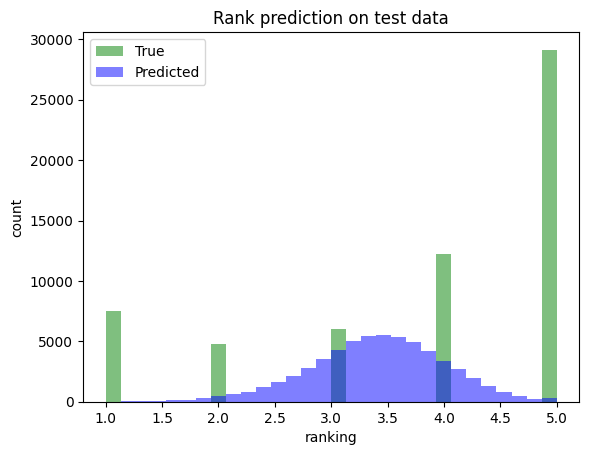

In [44]:
h_true = plt.hist(target.cpu(), bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(preds.cpu(), bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.title("Rank prediction on test data")
plt.show()

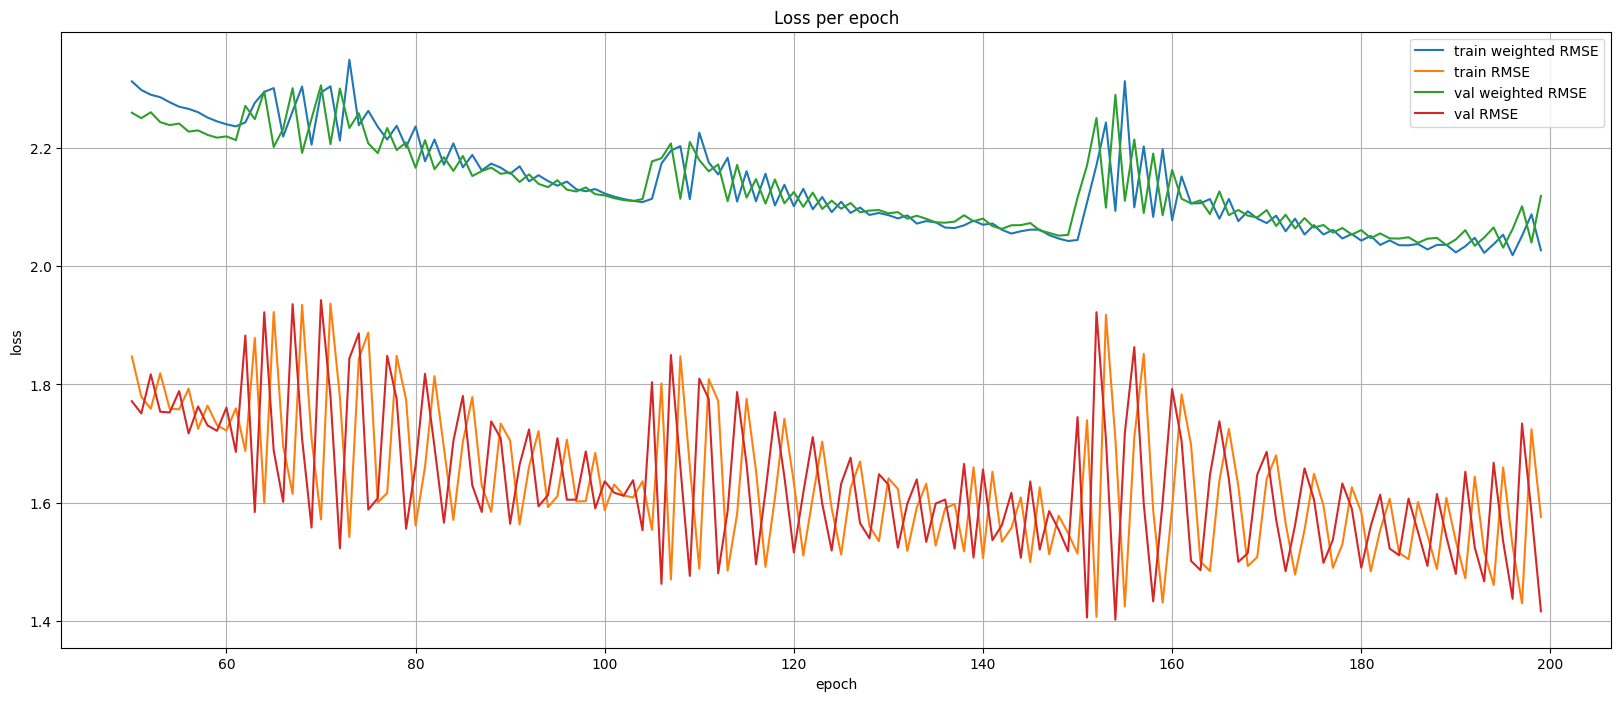

In [54]:
losses = np.array(losses)
e_start = 50
x_linspace = np.array(np.arange(e_start, n_epochs))
plt.figure(figsize=(20, 8))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(x_linspace, losses[:,0][e_start:],  '-', label="train weighted RMSE")
plt.plot(x_linspace, losses[:,1][e_start:],  '-', label="train RMSE")
plt.plot(x_linspace, losses[:,2][e_start:],  '-', label="val weighted RMSE")
plt.plot(x_linspace, losses[:,3][e_start:],  '-', label="val RMSE")
plt.legend()
plt.grid(True)
plt.title('Loss per epoch')
plt.show()

# Embedding + Classification

In [10]:
batch_size = 512

In [11]:
edge_label_index = train_data["user", "rating", "restaurant"].edge_label_index
edge_label = train_data["user", "rating", "restaurant"].edge_label
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[30] * 2,
    edge_label_index=(("user", "rating", "restaurant"), edge_label_index),
    edge_label=edge_label,
    batch_size=batch_size,
    shuffle=True,
)

edge_label_index = val_data["user", "rating", "restaurant"].edge_label_index
edge_label = val_data["user", "rating", "restaurant"].edge_label
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[30] * 2,
    edge_label_index=((["user", "rating", "restaurant"]), edge_label_index),
    edge_label=edge_label,
    batch_size=batch_size,
    shuffle=False,
)

test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[30] * 2,
    edge_label_index=((["user", "rating", "restaurant"]), edge_label_index),
    edge_label=edge_label,
    batch_size=batch_size,
    shuffle=False,
)


In [12]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# Classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user, x_restaurant, edge_label_index):
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_restaurant = x_restaurant[edge_label_index[1]]
        # Apply dot-product to get a prediction per supervision edge:
        embeds = (edge_feat_user * edge_feat_restaurant).sum(dim=-1)
        return embeds

class EmbeddingModel(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.user_lin = torch.nn.Linear(5, hidden_channels)
        self.restaurant_lin = torch.nn.Linear(640, hidden_channels)

        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.restaurant_emb = torch.nn.Embedding(data["restaurant"].num_nodes, hidden_channels)

        self.gnn = GNN(hidden_channels, hidden_channels)
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        
        self.classifier = Classifier()

    def forward(self, data: HeteroData):
        x_dict = {
          "user": self.user_lin(data['user'].x) + self.user_emb(data["user"].node_id),
          "restaurant": self.restaurant_lin(data['restaurant'].x) + self.restaurant_emb(data["restaurant"].node_id),
        } 
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["restaurant"],
            data["user", "rating", "restaurant"].edge_label_index,
        )
        return pred

In [15]:
model = EmbeddingModel(64)
gnn_model_summary(model)

+---------------------------------------------------------+--------------------+----------+
|                     Layer.Parameter                     | Param Tensor Shape | Param #  |
+---------------------------------------------------------+--------------------+----------+
|                     user_lin.weight                     |      [64, 5]       |   320    |
|                      user_lin.bias                      |        [64]        |    64    |
|                  restaurant_lin.weight                  |     [64, 640]      |  40960   |
|                   restaurant_lin.bias                   |        [64]        |    64    |
|                     user_emb.weight                     |    [290714, 64]    | 18605696 |
|                  restaurant_emb.weight                  |    [31217, 64]     | 1997888  |
|     gnn.conv1.user__rating__restaurant.lin_l.weight     |      [64, 64]      |   4096   |
|      gnn.conv1.user__rating__restaurant.lin_l.bias      |        [64]        |

In [16]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

min_val_loss = np.inf
min_train_loss = np.inf
prev_val_counts = 0
flag = False
best_base_model = None
n_epoch = 5
losses_cont = []

for epoch in range(1, n_epoch + 1):
    ct = datetime.now()
    if flag:
        print('')
        break
    total_examples = total_loss  = 0

    model.train()
    for sampled_data in tqdm(train_loader, desc=f'Epoch: {epoch}: - Training', total=len(train_loader)):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = torch.clamp(model(sampled_data), min = 1, max = 5) 
        ground_truth = sampled_data["user", "rating", "restaurant"].edge_label
        mse_loss = F.mse_loss(pred,ground_truth.float())
        mse_loss.backward()
        optimizer.step()
        total_loss += float(mse_loss) * pred.numel()
        total_examples += pred.numel()
    avg_train_loss = total_loss / total_examples

    # Calculate validation loss and stop when our loss starts increasing
    total_val_examples = total_val_loss = 0
    model.eval()
    for sampled_data in tqdm(val_loader, desc=f'Epoch: {epoch}: - Validation', total=len(val_loader)):
        with torch.no_grad():
            sampled_data.to(device)
            pred = torch.clamp(model(sampled_data), min = 1, max = 5) # Ratings should be minimum 1 and maximum 5
            ground_truth = sampled_data["user", "rating", "restaurant"].edge_label
            loss = F.mse_loss(pred, ground_truth.float())
            total_val_loss += float(loss) * pred.numel()
            total_val_examples += pred.numel()
    avg_val_loss = total_val_loss / total_val_examples

    losses_cont.append([avg_train_loss, avg_val_loss])

    if avg_val_loss > min_val_loss:
        prev_val_counts+=1
        if prev_val_counts==10:
            flag = True
            print('Break condition: No improvement in last 10 epochs...')
    else:
        min_val_loss = avg_val_loss
        min_train_loss = avg_train_loss
        prev_val_counts = 0
        best_base_model = model

    et = datetime.now() - ct
    if et < timedelta(minutes=1):
        et_str =  f"{int(et.total_seconds())} seconds"
    else:
        minutes, seconds = divmod(int(et.total_seconds()), 60)
        et_str = f"{minutes} minutes and {seconds} seconds"

    print(f"Training Loss: MSE: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")     
    print(f"{80*'-'} elapsed time: {et_str}")

Epoch: 1: - Validation: 100%|██████████| 117/117 [00:09<00:00, 12.66it/s]


Training Loss: MSE: 3.5763
Validation Loss: 3.3487
-------------------------------------------------------------------------------- elapsed time: 26 seconds


Epoch: 2: - Validation: 100%|██████████| 117/117 [00:09<00:00, 12.51it/s]


Training Loss: MSE: 3.4201
Validation Loss: 3.3487
-------------------------------------------------------------------------------- elapsed time: 26 seconds


Epoch: 3: - Validation: 100%|██████████| 117/117 [00:09<00:00, 12.36it/s]


Training Loss: MSE: 3.4014
Validation Loss: 3.3487
-------------------------------------------------------------------------------- elapsed time: 26 seconds


Epoch: 4: - Validation: 100%|██████████| 117/117 [00:09<00:00, 12.32it/s]


Training Loss: MSE: 3.6914
Validation Loss: 8.3643
-------------------------------------------------------------------------------- elapsed time: 26 seconds


Epoch: 5: - Validation: 100%|██████████| 117/117 [00:09<00:00, 11.82it/s]

Training Loss: MSE: 8.9602
Validation Loss: 9.5334
-------------------------------------------------------------------------------- elapsed time: 27 seconds


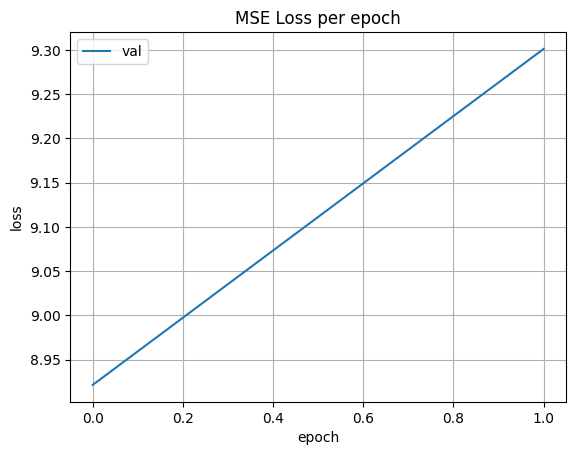

In [65]:
losses = np.array(losses_cont, dtype=np.float32)
plt.figure()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(losses[:,0], '-', label="train")
plt.plot(losses[:,1], '-', label="val")
plt.legend()
plt.grid(True)
plt.title('MSE Loss per epoch')
plt.show()

In [66]:
# Calculate test loss

total_test_loss = total_test_examples = 0
best_base_model.eval()
for sampled_data in tqdm(test_loader, desc='Loss on test set', total=len(test_loader)):
    with torch.no_grad():
        sampled_data.to(device)
        pred = torch.clamp(best_base_model(sampled_data), min = 1, max = 5) # Ratings should be minimum 1 and maximum 5
        ground_truth = sampled_data["user", "rating", "restaurant"].edge_label
        loss = F.mse_loss(pred,ground_truth.float())
        total_test_loss += float(loss) * pred.numel()
        total_test_examples += pred.numel()
avg_test_loss = total_test_loss / total_test_examples
print(f"Test Loss: {avg_test_loss:.4f}")

Loss on test set: 100%|██████████| 467/467 [00:20<00:00, 22.33it/s]

Test Loss: 9.7131
